In [1]:
from DarkMatter import *
from tqdm.notebook import trange

dwarf = "bootes"
events= Likelihood.eventdisplay.readData(dwarf, rawdata=True)
bkg = events[events[:,2] == 0.0]
signal = events[events[:,2] == 1.0]
binEdges = const.energyEdges

Welcome to JupyROOT 6.23/01


### Method: Extrapolation

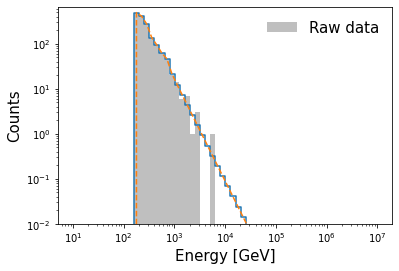

Warning in <TROOT::Append>: Replacing existing TH1: hNull (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hExp (Potential memory leak).


In [14]:
from scipy.optimize import curve_fit
def cstat(x, m, s=True):
    if s:
        lx = np.log(x)
        lx[lx == -np.inf] = 0
        lm = np.log(m)
        lm[lm == -np.inf] = 0
        
        return 2*sum(m-x+x*(np.nan_to_num(lx)-np.nan_to_num(lm)))
    else:
        return 2*(m-x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))
    

def rawdata_plot(events, binEdges, ylim=[0.1, None], ax=None, label="Raw data"):
    if ax == None:
        ax = plt.gca()
    y, x, etc = ax.hist(events, bins=binEdges,  histtype="stepfilled", label=label, color="gray", alpha=0.5)
#    ax.plot(events[:,None], np.full_like(events[:,None], ylim[0]*1.2), '|k', markeredgewidth=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel("Energy [GeV]", fontsize=15)
    ax.set_ylabel("Counts", fontsize=15)
    ax.legend(frameon=False, fontsize=15)
    return x, y

def cstat(x, m, s=True):
    if s:
        return 2*sum(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))
    else:
        return 2*(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))
    
    
x, y = rawdata_plot(bkg[:,0], binEdges, ylim = [1e-2, None])
x_ctr = center_pt(x)

y_ex = np.asarray(Likelihood.bkg_ex_1D(bkg, binEdges))

plt.step(x_ctr, y_ex, where="mid", label="Extrapolation")
plt.plot(x_ctr, y_ex, ls="--")

hBkg = TH1D("hNull", "hNull", len(binEdges)-1, binEdges)
hBkg_ex = TH1D("hExp", "hExp", len(binEdges)-1, binEdges)

for i in range(1, len(x)):
    hBkg.SetBinContent(i, y[i-1])
    hBkg_ex.SetBinContent(i, y_ex[i-1])


In [68]:

cstat_dist = []
y_gen_dist = []
for i in trange(10000):
    ex_bkg = [hBkg_ex.GetRandom() for i in range(len(bkg))]
    y_gen, x = np.histogram(ex_bkg, binEdges)
    x = center_pt(x)
    y_gen_dist.append(y_gen)
    c = cstat(y_gen[x>300], y_ex[x>300])
    cstat_dist.append(c)
y_gen_dist = np.asarray(y_gen_dist)

  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-14-d1cb886501de>:29: RuntimeWarning: divide by zero encountered in log
  return 2*sum(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))


In [69]:
percentile = []
for i in range(len(binEdges)-1):
    percentile.append([np.percentile(y_gen_dist[:,i], 50), 
                       np.percentile(y_gen_dist[:,i], 16), 
                       np.percentile(y_gen_dist[:,i], 84)])
percentile = np.asarray(percentile)

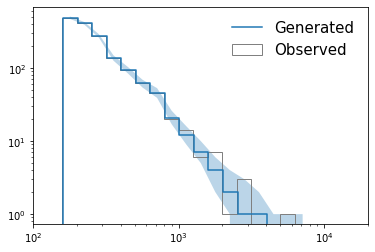

In [72]:
plt.step(x_ctr, percentile[:,0], where="mid", label="Generated")
plt.fill_between(x_ctr, percentile[:,1],  percentile[:,2], alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.hist(bkg[:,0], binEdges, color="gray", histtype="step", label="Observed")
plt.xlim(100, 20000)
plt.legend(fontsize=15, frameon=False)

<ipython-input-14-d1cb886501de>:29: RuntimeWarning: divide by zero encountered in log
  return 2*sum(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))


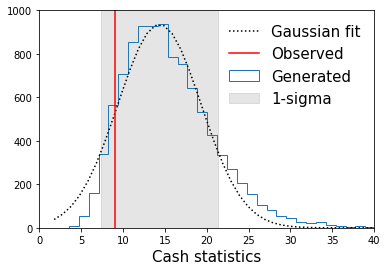

In [83]:
gaus = lambda x, n, x0, sig: n*np.exp(-(x-x0)**2./sig**2.)

cstat_y, cstat_x, z = plt.hist(cstat_dist, bins=40, histtype="step", label="Generated")
cstat_x = (cstat_x[1:]+cstat_x[:-1])/2.
p, cov = curve_fit(gaus, cstat_x, cstat_y, p0=(20, np.average(cstat_dist), 4))
fitx = np.linspace(min(cstat_dist)/2, max(cstat_dist)*2, 100)
plt.plot(fitx, gaus(fitx, *p), color="k", ls=":", label="Gaussian fit")
plt.axvline(cstat(y[x_ctr>300], y_ex[x_ctr>300]), color="r", label="Observed")
plt.fill_betweenx([0, 4000], p[1]-p[2], p[1]+p[2], color="k", label="1-sigma", alpha=0.1)

plt.xlim(0, 40)
plt.ylim(0, 1000)
plt.xlabel("Cash statistics", fontsize=15)
plt.legend(fontsize=15, frameon=False)